In [1]:
import cv2
import matplotlib.pyplot as plt
import os
print(os.getcwd())

C:\diffdepth\notebooks


In [2]:
import pandas as pd
df = pd.read_csv("../data/nyu2_train.csv", header=None)
df.columns = ["rgb_image","depth_image"]
print(df.head())

                                      rgb_image  \
0   data/nyu2_train/living_room_0038_out/37.jpg   
1  data/nyu2_train/living_room_0038_out/115.jpg   
2    data/nyu2_train/living_room_0038_out/6.jpg   
3   data/nyu2_train/living_room_0038_out/49.jpg   
4  data/nyu2_train/living_room_0038_out/152.jpg   

                                    depth_image  
0   data/nyu2_train/living_room_0038_out/37.png  
1  data/nyu2_train/living_room_0038_out/115.png  
2    data/nyu2_train/living_room_0038_out/6.png  
3   data/nyu2_train/living_room_0038_out/49.png  
4  data/nyu2_train/living_room_0038_out/152.png  


# Preprocessing
## Creating class

In [5]:
import torch
from torch.utils.data import Dataset
import cv2
import pandas as pd
import os
import torchvision.transforms as T

class NYUDepthDataset(Dataset):
    def __init__(self, csv_path, project_root, size=(256,256)):
        self.df = pd.read_csv(csv_path, header=None)
        self.df.columns = ["rgb_path", "depth_path"]
        self.project_root = project_root
        self.resize = T.Resize(size)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.project_root, self.df.iloc[idx]["rgb_path"])
        depth_path = os.path.join(self.project_root, self.df.iloc[idx]["depth_path"])

        rgb = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

        rgb = torch.tensor(rgb).permute(2,0,1).float() / 255.0
        depth = torch.tensor(depth).unsqueeze(0).float()

        rgb = self.resize(rgb)
        depth = self.resize(depth)

        return {"rgb": rgb, "depth": depth}

In [6]:
PROJECT_ROOT = os.path.abspath("..")
print("PROJECT_ROOT:", PROJECT_ROOT)

dataset = NYUDepthDataset(
    csv_path="../data/nyu2_train.csv",
    project_root=PROJECT_ROOT
)

sample = dataset[0]
print(sample["rgb"].shape)
print(sample["depth"].shape)

PROJECT_ROOT: C:\diffdepth
torch.Size([3, 256, 256])
torch.Size([1, 256, 256])


dtype:  torch.float32
min:  30.999998092651367
max:  253.15211486816406


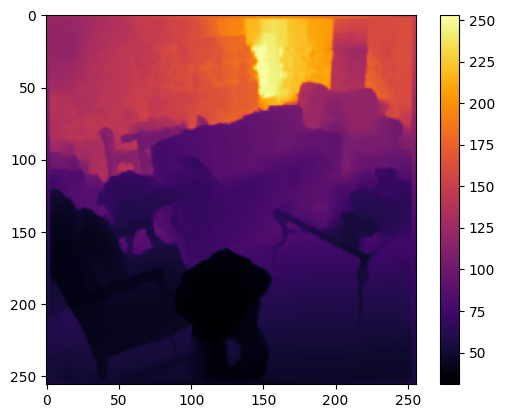

In [8]:
sample = dataset[0]
depth = sample["depth"]
print("dtype: ", depth.dtype)
print("min: ", depth.min().item())
print("max: ", depth.max().item())

import matplotlib.pyplot as plt
plt.imshow(depth[0], cmap="inferno")
plt.colorbar()
plt.show()

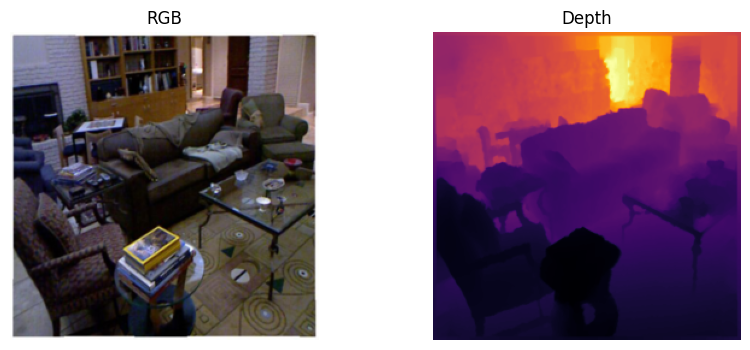

In [9]:
sample = dataset[0]
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.imshow(sample["rgb"].permute(1,2,0))
plt.title("RGB")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sample["depth"][0], cmap="inferno")
plt.title("Depth")
plt.axis("off")
plt.show()

In [10]:
from tqdm import tqdm
import os
import torch

CHUNK_SIZE = 100

# External drive path
SAVE_ROOT = "D:/diffdepth_data/processed/train"
os.makedirs(SAVE_ROOT, exist_ok=True)

buffer = []
chunk_id = 0

for i in tqdm(range(len(dataset))):
    buffer.append(dataset[i])

    if len(buffer) == CHUNK_SIZE:
        torch.save(
            buffer,
            os.path.join(SAVE_ROOT, f"chunk_{chunk_id:04d}.pt"),
            _use_new_zipfile_serialization=False
        )
        buffer = []
        chunk_id += 1

# save remaining samples
if buffer:
    torch.save(
        buffer,
        os.path.join(SAVE_ROOT, f"chunk_{chunk_id:04d}_last.pt"),
        _use_new_zipfile_serialization=False
    )

print("All data saved to external hard drive (D:)")

100%|███████████████████████████████| 50688/50688 [14:23<00:00, 58.71it/s]


All data saved to external hard drive (D:)
